In [1]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, GRU, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [2]:
df_train = pd.read_csv('../Dataset/depression tweet/train2Data.csv')
df_test = pd.read_csv('../Dataset/depression tweet/test2Data.csv')

In [3]:
df_train.head()

,Tweets,Label
0,damn taking this personality quiz and realizin...,1
1,remember experiencing as kid what now realize ...,1
2,damn louis really did pull me out of my depres...,1
3,my depression is really kicking my ass right n...,1
4,feel like my night is going bad family calling...,1


In [4]:
df_test.head()

,Tweets,Label
0,just know what ur going through battle depress...,1
1,wow depression and anxiety really tryna come f...,1
2,you aint making joke about someones depression...,1
3,why do insta meme pages post videos of naked w...,1
4,cant handle school anymore but hate in person ...,1


In [5]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

In [6]:
EMBEDDING_FILE = 'wiki-news-300d-1M.vec'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

In [7]:
import nltk
# Uncomment to download "stopwords"
#nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [8]:
import re

# Preprocess text
X_train_preprocessed = [text_preprocessing(text) for text in df_train['Tweets'].values]
X_val_preprocessed = [text_preprocessing(text) for text in df_val['Tweets'].values]
X_test_preprocessed = [text_preprocessing(text) for text in df_test['Tweets'].values]

In [9]:
X_train_preprocessed

['definition mental illness issues uncontrollable suffer severe bouts depression cannot shap anymore someone violent outburst mistake making somehow excusing racism',
 'buck dodgers left open second guessing feel like thats dodgers fans ever included',
 'whatever dont read fan fiction dear harry larry stylinson unless want depressed rest ur life cry every day not even halfway trying not cry sitting mum wait till sleeps can go',
 'im stressed depressed im combination pizza hut taco bell',
 'know ok not hurt left anyway started really nice near end really mean know know happened',
 'totally agree dragged forever races amc skimp character development',
 'test new era aus team also see tough months not ss dw cb whole regained respect also role justin langer coach many things simply',
 'worst putting fake smile everyday look weak deep want sleep cry not depressed anything simply fucking stressed',
 'reminded today much older feel literally pulled hammy teaching kid rollerblade defense pulle

In [10]:
MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train_preprocessed + X_val_preprocessed)

sequences_train = tokenizer.texts_to_sequences(X_train_preprocessed)
sequences_val = tokenizer.texts_to_sequences(X_val_preprocessed)
sequences_test = tokenizer.texts_to_sequences(X_test_preprocessed)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 36000 unique tokens


In [11]:
MAX_SEQUENCE_LENGTH = 140
data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
data_val = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data_train.shape)

Shape of data tensor: (24800, 140)


In [12]:
EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIM))

In [13]:
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < len(word_index):
        embedding_matrix[idx] = word2vec.word_vec(word)

In [14]:
print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0462      0.0259      0.011      ...  0.0542     -0.0282
  -0.24680001]
 [-0.0637     -0.073      -0.0434     ...  0.31209999  0.0271
  -0.0763    ]
 ...
 [-0.0307      0.1213      0.1096     ...  0.18089999 -0.0882
  -0.14399999]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.1821      0.0913     -0.102      ...  0.0492     -0.0539
  -0.0942    ]]
(36000, 300)


In [15]:
# Assigning labels to the depressive tweets and random tweets data
labels_train = df_train[' Label'].values
labels_val = df_val[' Label'].values
labels_test = df_test[' Label'].values

In [16]:
print(data_train)
print(data_val)
print(data_test)
print(labels_train)
print(labels_val)
print(labels_test)

[[   0    0    0 ...  810 8355 2139]
 [   0    0    0 ...  522   68 2890]
 [   0    0    0 ... 5903    8   30]
 ...
 [   0    0    0 ...    4  197  602]
 [   0    0    0 ...  156    9  618]
 [   0    0    0 ...  157  272   67]]
[[    0     0     0 ...    14   230  2405]
 [    0     0     0 ...    49   564   310]
 [    0     0     0 ...  1189   743    23]
 ...
 [    0     0     0 ...   544     3   183]
 [    0     0     0 ...  2181    17   231]
 [    0     0     0 ...    29    54 11676]]
[[   0    0    0 ...  225   35 3800]
 [   0    0    0 ... 1712    5   11]
 [   0    0    0 ... 2502  103   23]
 ...
 [   0    0    0 ... 1512 7187  179]
 [   0    0    0 ...  251   69 1595]
 [   0    0    0 ...  466 8317 1640]]
[1 0 1 ... 1 1 0]
[0 1 1 ... 1 0 0]
[1 1 1 ... 0 0 0]


In [17]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [18]:
import tensorflow as tf
with tf.device('/device:GPU:1'):
    model = Sequential()
    # Embedded layer
    model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # Convolutional Layer
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    # LSTM Layer
    model.add(LSTM(300))
    #model.add(GRU(300))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          10800000  
_________________________________________________________________
conv1d (Conv1D)              (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               399600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model.fit(data_train, labels_train, validation_data=(data_val, labels_val), epochs=5, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/5
775/775 [==============================] - 8s 10ms/step - loss: 0.0749 - acc: 0.9729 - val_loss: 0.0214 - val_acc: 0.9945
Epoch 2/5
775/775 [==============================] - 7s 10ms/step - loss: 0.0206 - acc: 0.9942 - val_loss: 0.0240 - val_acc: 0.9927
Epoch 3/5
775/775 [==============================] - 7s 10ms/step - loss: 0.0154 - acc: 0.9955 - val_loss: 0.0166 - val_acc: 0.9958
Epoch 4/5
775/775 [==============================] - 7s 10ms/step - loss: 0.0118 - acc: 0.9963 - val_loss: 0.0273 - val_acc: 0.9910
Epoch 5/5
775/775 [==============================] - 7s 10ms/step - loss: 0.0081 - acc: 0.9973 - val_loss: 0.0157 - val_acc: 0.9953


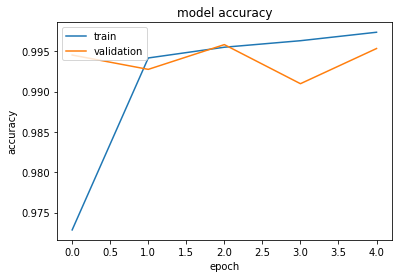

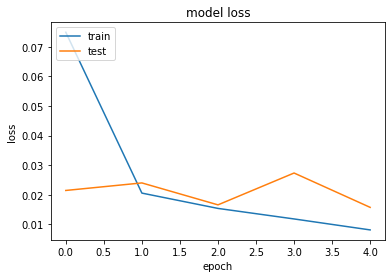

In [20]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model.predict(data_test)
    labels_pred = np.round(labels_pred.flatten())
    accuracy = accuracy_score(labels_test, labels_pred)
    f1 = f1_score(labels_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(labels_test, labels_pred))

Accuracy: 99.74%
F1 Score: 99.74
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     16000

    accuracy                           1.00     31000
   macro avg       1.00      1.00      1.00     31000
weighted avg       1.00      1.00      1.00     31000



In [22]:
model.save('model/word2vec_CNN_LSTM-Depression.h5')

In [23]:
import tensorflow as tf
with tf.device('/device:GPU:1'):
    model2 = Sequential()
    # Embedded layer
    model2.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # Convolutional Layer
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(GlobalAveragePooling1D())
    #model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    # LSTM Layer
    model2.add(LSTM(300))
    #model.add(GRU(300))
    model2.add(Dropout(0.2))
    model2.add(Dense(1, activation='sigmoid'))

    model2.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          10800000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 11,521,501
Trainable params: 721,501
Non-trainable params: 10,800,000
_________________________________________________________________
None


In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model2.fit(data_train, labels_train, validation_data=(data_val, labels_val), epochs=5, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/5
775/775 [==============================] - 9s 12ms/step - loss: 0.0830 - acc: 0.9742 - val_loss: 0.0212 - val_acc: 0.9956
Epoch 2/5
775/775 [==============================] - 9s 12ms/step - loss: 0.0382 - acc: 0.9911 - val_loss: 0.0223 - val_acc: 0.9955
Epoch 3/5
775/775 [==============================] - 9s 12ms/step - loss: 0.0211 - acc: 0.9946 - val_loss: 0.0425 - val_acc: 0.9910
Epoch 4/5
775/775 [==============================] - 9s 12ms/step - loss: 0.0163 - acc: 0.9956 - val_loss: 0.0186 - val_acc: 0.9953
Epoch 5/5
775/775 [==============================] - 9s 12ms/step - loss: 0.0115 - acc: 0.9971 - val_loss: 0.0229 - val_acc: 0.9937


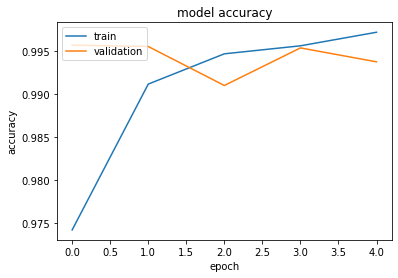

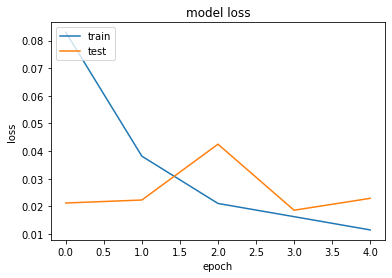

In [25]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model2.predict(data_test)
    labels_pred = np.round(labels_pred.flatten())
    accuracy = accuracy_score(labels_test, labels_pred)
    f1 = f1_score(labels_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(labels_test, labels_pred))

Accuracy: 99.57%
F1 Score: 99.57
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15000
           1       0.99      1.00      1.00     16000

    accuracy                           1.00     31000
   macro avg       1.00      1.00      1.00     31000
weighted avg       1.00      1.00      1.00     31000



In [27]:
model2.save('model/word2vec_LSTM-Depression.h5')

In [28]:
import tensorflow as tf
with tf.device('/device:GPU:1'):
    model3 = Sequential()
    # Embedded layer
    model3.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # Convolutional Layer
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(GlobalAveragePooling1D())
    #model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    # LSTM Layer
    model3.add(Bidirectional(LSTM(300)))
    #model.add(GRU(300))
    model3.add(Dropout(0.2))
    model3.add(Dense(1, activation='sigmoid'))

    model3.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 300)          10800000  
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 601       
Total params: 12,243,001
Trainable params: 1,443,001
Non-trainable params: 10,800,000
_________________________________________________________________
None


In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model3.fit(data_train, labels_train, validation_data=(data_val, labels_val), epochs=5, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/5
775/775 [==============================] - 17s 21ms/step - loss: 0.0810 - acc: 0.9731 - val_loss: 0.0289 - val_acc: 0.9937
Epoch 2/5
775/775 [==============================] - 16s 21ms/step - loss: 0.0253 - acc: 0.9933 - val_loss: 0.0187 - val_acc: 0.9963
Epoch 3/5
775/775 [==============================] - 17s 21ms/step - loss: 0.0191 - acc: 0.9953 - val_loss: 0.0163 - val_acc: 0.9956
Epoch 4/5
775/775 [==============================] - 16s 21ms/step - loss: 0.0146 - acc: 0.9964 - val_loss: 0.0165 - val_acc: 0.9961
Epoch 5/5
775/775 [==============================] - 17s 21ms/step - loss: 0.0145 - acc: 0.9960 - val_loss: 0.0193 - val_acc: 0.9952


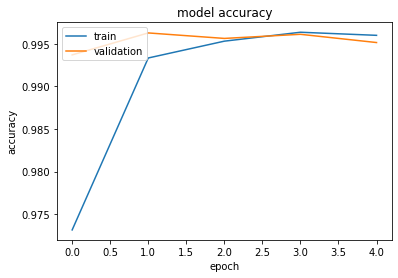

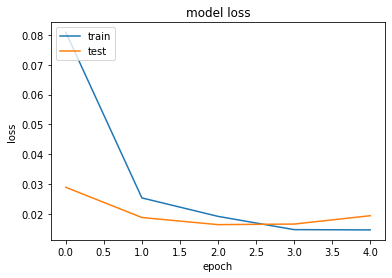

In [30]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model3.predict(data_test)
    labels_pred = np.round(labels_pred.flatten())
    accuracy = accuracy_score(labels_test, labels_pred)
    f1 = f1_score(labels_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(labels_test, labels_pred))

Accuracy: 99.75%
F1 Score: 99.75
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     16000

    accuracy                           1.00     31000
   macro avg       1.00      1.00      1.00     31000
weighted avg       1.00      1.00      1.00     31000



In [32]:
model3.save('model/word2vec_BiLSTM-Depression.h5')